In [1]:
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
import pandas as pd
import tensorflow as tf
from keras_tuner import RandomSearch

from constants.klass_mappings import klass_mappings
from constants.transliterations import transliterations
from models.model_2 import Model2

In [2]:
X_train = pd.read_csv('./data/train_x.csv')
X_test = pd.read_csv('./data/test_x.csv')
y_train = pd.read_csv('./data/train_y.csv')
y_test = pd.read_csv('./data/test_y.csv')

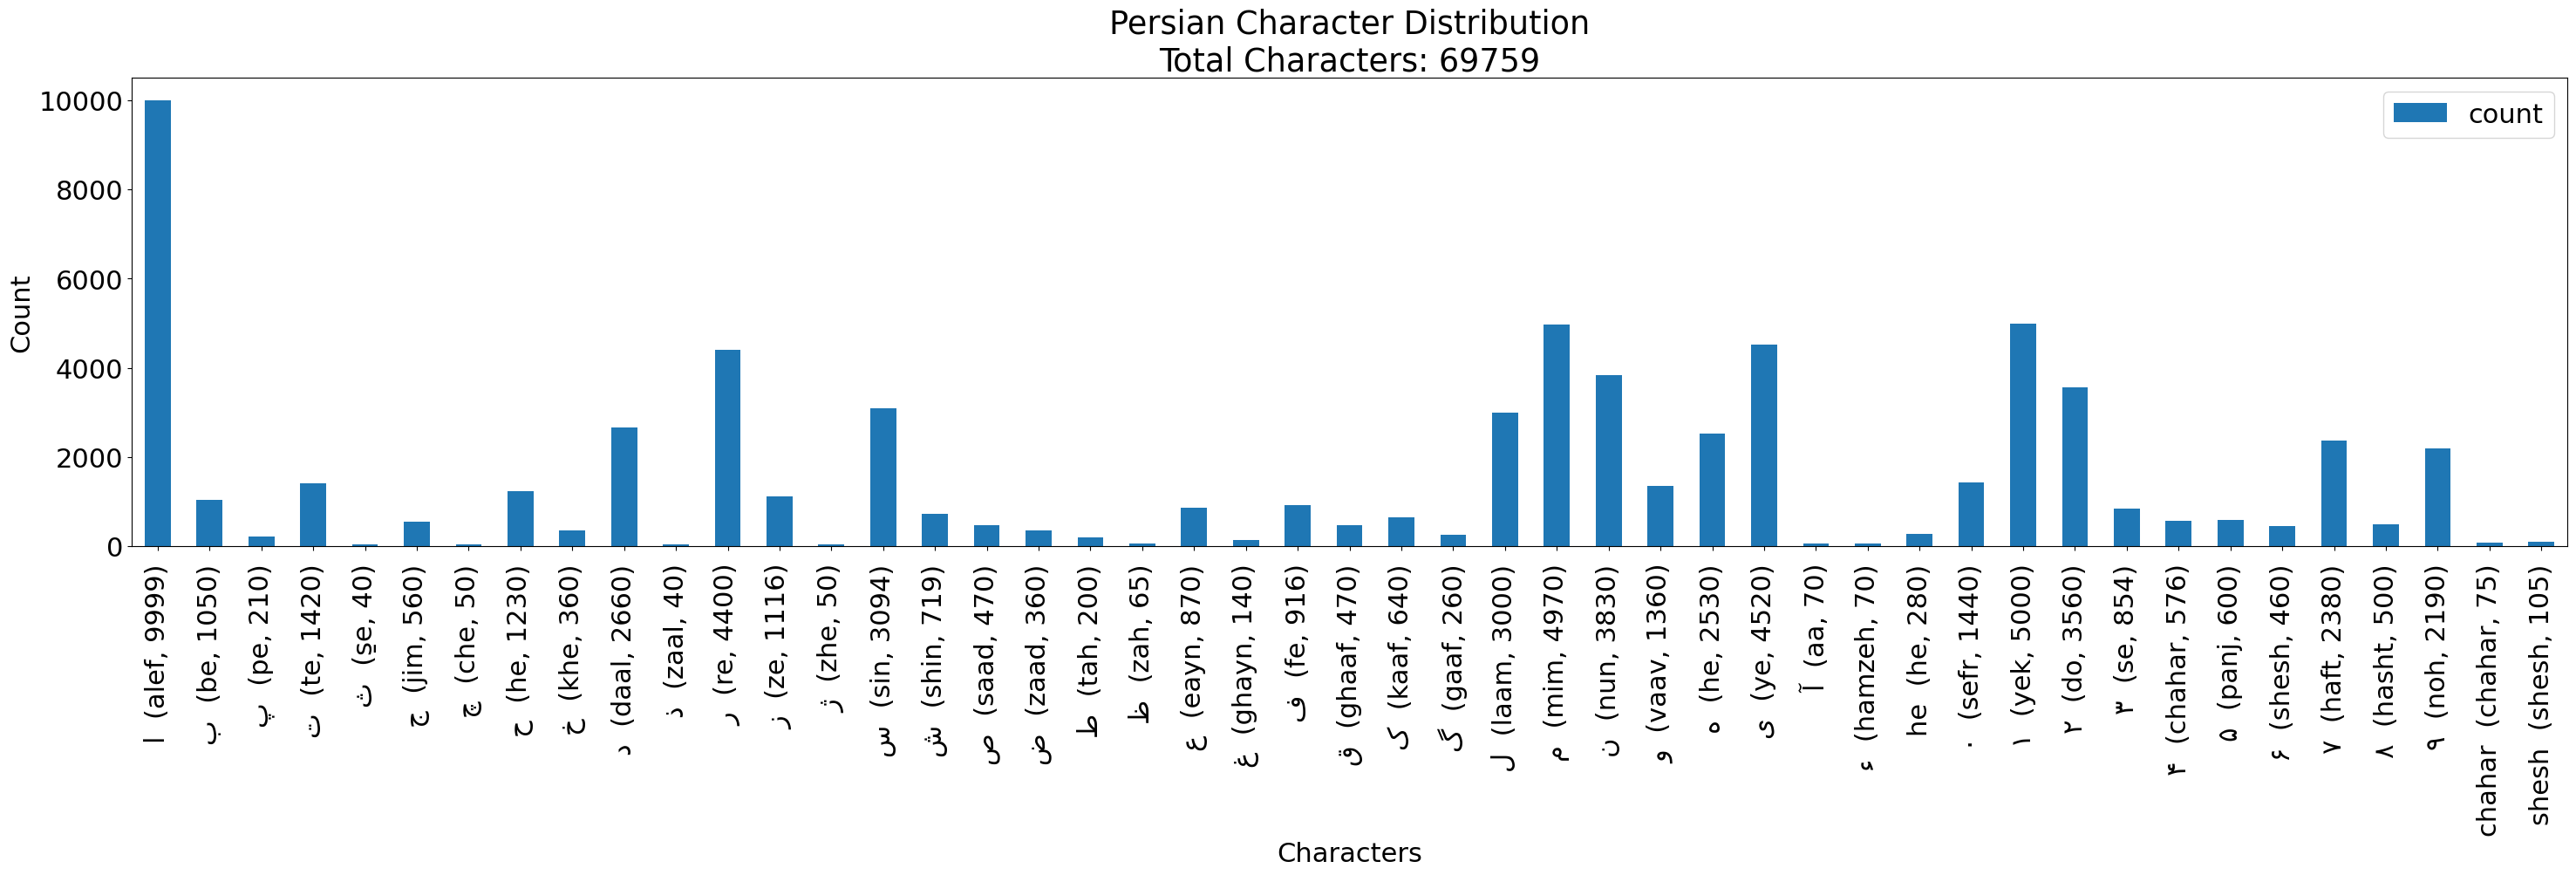

In [3]:
plt.rcParams.update({'font.size': 22})
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
mappings_df = y_train.groupby('1')['1'].count().to_frame()
mappings_df = mappings_df.rename(columns={'1': 'count'})
mappings_df['klass'] = mappings_df.index
mappings_df['character'] = mappings_df['klass'].apply(lambda x: klass_mappings[x])
mappings_df['transliteration'] = mappings_df['klass'].apply(lambda x: transliterations[x])
mappings_df['klass_transliteration'] = mappings_df['klass'].apply(lambda x: f'{klass_mappings[x]}  ({transliterations[x]}, {mappings_df["count"][x]}) ')
mappings_df['proportion'] = mappings_df['klass'].apply(lambda x: mappings_df['count'][x] / mappings_df['count'][1])
fig = mappings_df[['klass_transliteration', 'count']].plot(kind='bar', xlabel=f'Characters', ylabel='Count', title=f"Persian Character Distribution\nTotal Characters: {X_train.shape[0]}", x='klass_transliteration', figsize=(30,10)).get_figure()
fig.tight_layout()
fig.subplots_adjust(bottom=0.35)
fig.savefig('./images/character_distribution.png')

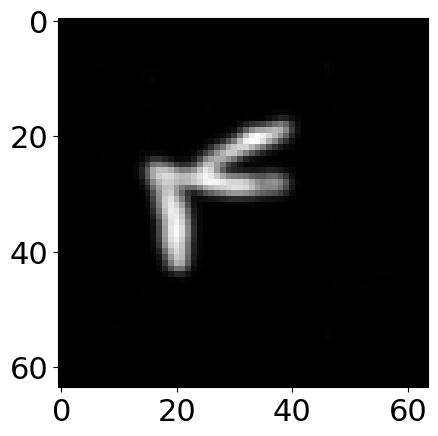

In [4]:
plt.imshow(X_train.iloc[18027].values.reshape((64, 64)), cmap = "gray_r")

In [5]:
# take a small random sample for tuning purposes
X_train_sample = X_train.sample(n=15000, random_state=6)
y_train_sample = y_train.loc[X_train_sample.index]
y_train_sample.groupby("1")["1"].count()

1
1     2192
2      223
3       37
4      304
5       12
6      115
7       14
8      261
9       70
10     549
11      10
12     953
13     225
14       6
15     699
16     168
17     103
18      83
19      39
20       6
21     193
22      32
23     185
24     104
25     125
26      62
27     649
28    1080
29     840
30     270
31     517
32     919
33      15
34      20
35      69
36     317
37    1102
38     773
39     185
40     127
41     120
42     105
43     519
44     121
45     451
46       9
47      22
Name: 1, dtype: int64

In [6]:
num_classes = 48
input_shape = (4096, 1)
desired_shape = (64, 64, 1)

In [7]:
tuner = RandomSearch(
    Model2(num_classes=num_classes, input_shape=input_shape, desired_shape=desired_shape),
        objective="val_accuracy",
        max_trials=100,
        max_consecutive_failed_trials=10,
        executions_per_trial=1,
        directory='tuning',
        project_name="hyperparams",
        overwrite=True
    )
tuner.search(X_train_sample, y_train_sample, epochs=1, validation_data=(X_train_sample, y_train_sample))

Trial 100 Complete [00h 00m 01s]

Best val_accuracy So Far: 0.15213333070278168
Total elapsed time: 00h 13m 06s


In [11]:
model = tuner.get_best_models(num_models=1)[0]

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (None, 4096, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 4096, 1)        │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 4096, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 61, 61, 20)     │           340 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 20, 20, 20)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 48)             │       384,048 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 384,388 (1.47 MB)

 Trainable params: 384,388 (1.47 MB)

 Non-trainable params: 0 (0.00 B)

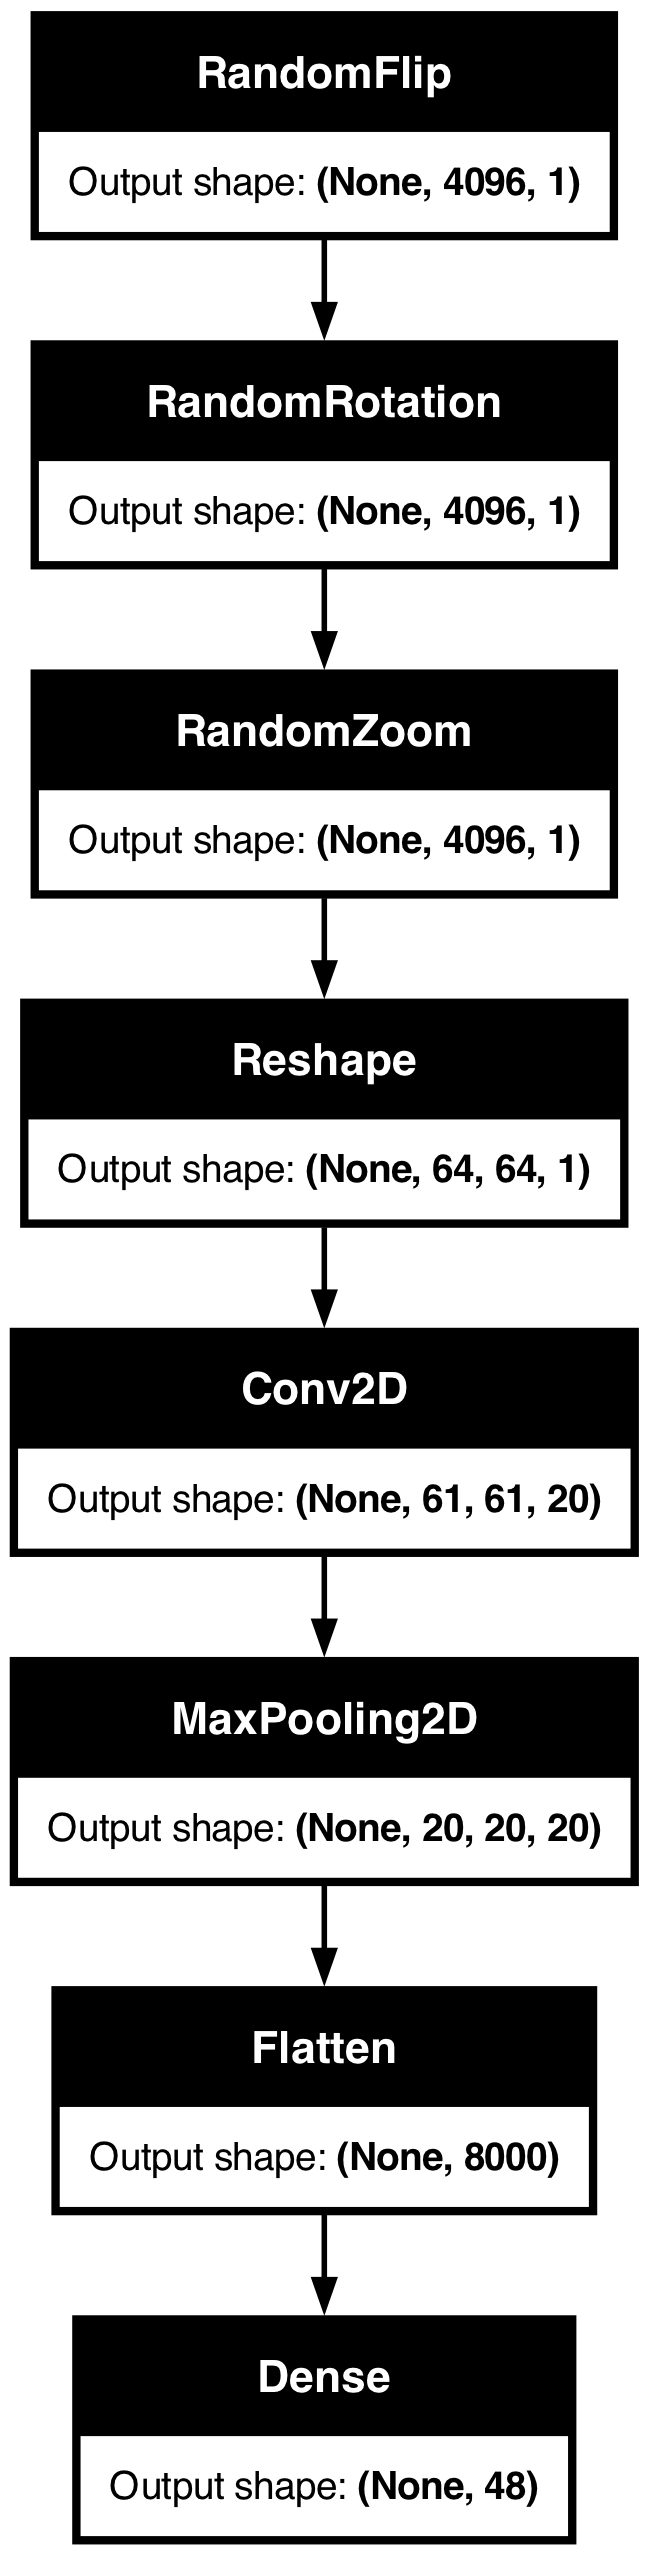

In [9]:
tf.keras.utils.plot_model(model, to_file='./images/model_2.png', show_shapes=True)

In [10]:
best_hyperparams = tuner.get_best_hyperparameters(10)[0]
best_hyperparams.values

{'conv_2_filter': 20,
 'conv_2_kernel': 4,
 'activation': 'relu',
 'l1': 0.1,
 'l2': 0.01,
 'pool_size': 3,
 'strides': 3,
 'optimizer': 'adam',
 'loss': 'sparse_categorical_crossentropy',
 'batch_size': 20}